<a href="https://colab.research.google.com/github/ted-M-tech/data-science-1.3M-linkedin-jobs-skills/blob/makoto%2Fjob_skill_title/job_title_and_skill_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Job titles and skills Analysis
This notebook provides a comprehensive deep dive into the dynamics of the job titles and skills, leveraging a substantial LinkedIn Job Postings and Skills dataset.    
Our primary objective is to uncover prevailing trends and critical insights that shape employment landscapes.

We will focus on two key areas:

**Job Position Trend Analysis**: Identifying and analyzing popular and emerging job titles to understand current market demands and shifts.    

**Skills Analysis:** Pinpointing the most sought-after skills by employers, and examining how these skills correlate with specific job roles and geographic locations

# SET UP DATA

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asaniczka/1-3m-linkedin-jobs-and-skills-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '1-3m-linkedin-jobs-and-skills-2024' dataset.
Path to dataset files: /kaggle/input/1-3m-linkedin-jobs-and-skills-2024


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import countDistinct, split, explode, trim, lower, regexp_replace, col, length, to_timestamp
import os
import pandas as pd

In [ ]:
# 1. Initialize the Session
spark = SparkSession.builder.appName("LinkedInAnalysis").getOrCreate()

jobs_file_path = os.path.join(path, "linkedin_job_postings.csv")
skills_file_path = os.path.join(path, "job_skills.csv")
summary_file_path = os.path.join(path, "job_summary.csv")

In [ ]:
# 2. Load the datasets
df_jobs = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .option("multiline","true")\
  .option("quote", "\"")\
  .option("escape", "\"")\
  .load(jobs_file_path)

# Sanity Check
print("Sanity Check: Total rows are matching - ", df_jobs.count() == 1348454) # matching total rows
print("Sanity Check: No unexpected nulls, with 10% margin of error - ", df_jobs.count() - df_jobs.na.drop().count() < (30*1.1) ) # checking for unexpected nulls, with 10% margin of error


df_skills = spark.read.csv(skills_file_path, header=True, inferSchema=True)

Sanity Check: Total rows are matching -  True
Sanity Check: No unexpected nulls, with 10% margin of error -  True


## CLEANING

Jobs Data Cleaning

In [ ]:
df_jobs_clean = df_jobs.withColumn(
    "job_title_clean",
    regexp_replace(col("job_title"), r"[^a-zA-Z0-9\s\-\/\&]", "")
)
df_jobs_clean = df_jobs_clean.filter(
    (col("company").isNotNull())
)
df_jobs_clean = df_jobs_clean.withColumn("got_summary", col("got_summary").cast(BooleanType())) \
            .withColumn("got_ner", col("got_ner").cast(BooleanType())) \
            .withColumn("is_being_worked", col("is_being_worked").cast(BooleanType())) \
            .withColumn("first_seen", to_timestamp(col("first_seen"), "yyyy-MM-dd"))

# Drop rows with null values in critical columns
df_jobs_clean = df_jobs_clean.dropna(subset=["job_title", "job_location", "first_seen"])
df_skills = df_skills.dropna(subset=["job_skills"])

display(df_jobs_clean.limit(5).toPandas())


,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_title_clean
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.002560,True,True,False,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite,Account Executive - Dispensing NorCal/Northern...
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.881370,True,True,False,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite,Registered Nurse - RN Care Manager
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126,True,True,False,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite,RESTAURANT SUPERVISOR - THE FORKLIFT
3,https://www.linkedin.com/jobs/view/independent...,2024-01-21 07:40:00.308133,True,True,False,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite,Independent Real Estate Agent
4,https://www.linkedin.com/jobs/view/group-unit-...,2024-01-19 09:45:09.215838,False,False,False,Group/Unit Supervisor (Systems Support Manager...,"IRS, Office of Chief Counsel","Chamblee, GA",2024-01-17,Gadsden,United States,Supervisor Travel-Information Center,Mid senior,Onsite,Group/Unit Supervisor Systems Support Manager TSS


# Analysis

## Prepare Job-Skill Data

Merge `df_jobs_clean` and `df_skills` on `job_link` to create a unified dataset of jobs and their associated skills

In [ ]:
df_jobs_with_skills = df_jobs_clean.join(df_skills, on='job_link', how='inner')
print("\nSample rows of df_jobs_with_skills:")
display(df_jobs_with_skills.limit(1).toPandas())


Sample rows of df_jobs_with_skills:


,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_title_clean,job_skills
0,https://ae.linkedin.com/jobs/view/evs-operator...,2024-01-21 07:21:39.439697,True,True,False,EVS Operator,Sundus,"Abu Dhabi, Abu Dhabi Emirate, United Arab Emir...",2024-01-17,Saint Joseph,United States,Unit Operator,Mid senior,Onsite,EVS Operator,"EVS, EVS Operator, Production, Highlight Packa..."


## Top 10 Job Titles

In [ ]:
df_jobs_clean.createOrReplaceTempView("jobs")
top_10_job_titles_sql = """SELECT job_title_clean, COUNT(*) AS count
                        FROM jobs
                        GROUP BY job_title_clean
                        ORDER BY count DESC
                        LIMIT 10;"""
top_10_job_titles = spark.sql(top_10_job_titles_sql)
top_10_job_titles.toPandas()


,job_title_clean,count
0,LEAD SALES ASSOCIATE-FT,7325
1,Shift Manager,5856
2,First Year Tax Professional,5356
3,Assistant Manager,5346
4,Customer Service Representative,5204
5,LEAD SALES ASSOCIATE-PT,4924
6,Store Manager,4792
7,CUSTOMER SERVICE REPRESENTATIVE,4218
8,Registered Nurse,4192
9,Hourly Supervisor & Training,2955


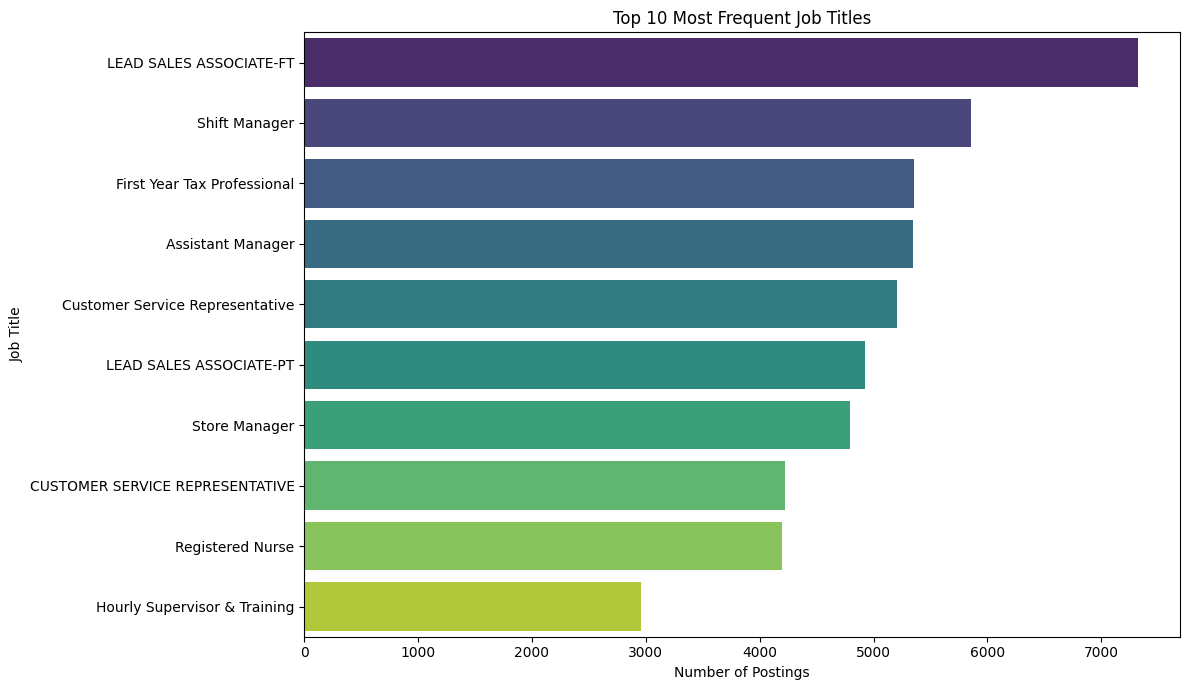

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_10_job_titles_pd = top_10_job_titles.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(x='count', y='job_title_clean', data=top_10_job_titles_pd, palette='viridis', hue='job_title_clean', legend=False)
plt.title('Top 10 Most Frequent Job Titles')
plt.xlabel('Number of Postings')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

## Top 20 Skills


**Reasoning**:
1. extract individual skills from the 'job_skills' column by splitting them and then exploding them into separate rows.    
2. clean and standardize the extracted skills by trimming whitespace and converting them to lowercase.
3. count the occurrences of each unique skill to prepare for identifying the top skills.



In [ ]:
df_skills_exploded = df_jobs_with_skills.withColumn("skill", explode(split(col("job_skills"), ",")))
df_skills_exploded = df_skills_exploded.withColumn("skill", trim(lower(col("skill"))))
skill_counts = df_skills_exploded.groupBy("skill").count().orderBy(col("count").desc())

print("Sample of skill_counts:")
skill_counts.show(5)

Sample of skill_counts:
+--------------------+------+
|               skill| count|
+--------------------+------+
|       communication|370041|
|    customer service|278029|
|            teamwork|227543|
|communication skills|195833|
|          leadership|185136|
+--------------------+------+
only showing top 5 rows


/tmp/ipython-input-3776181639.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='skill', data=top_20_skills, palette='viridis')


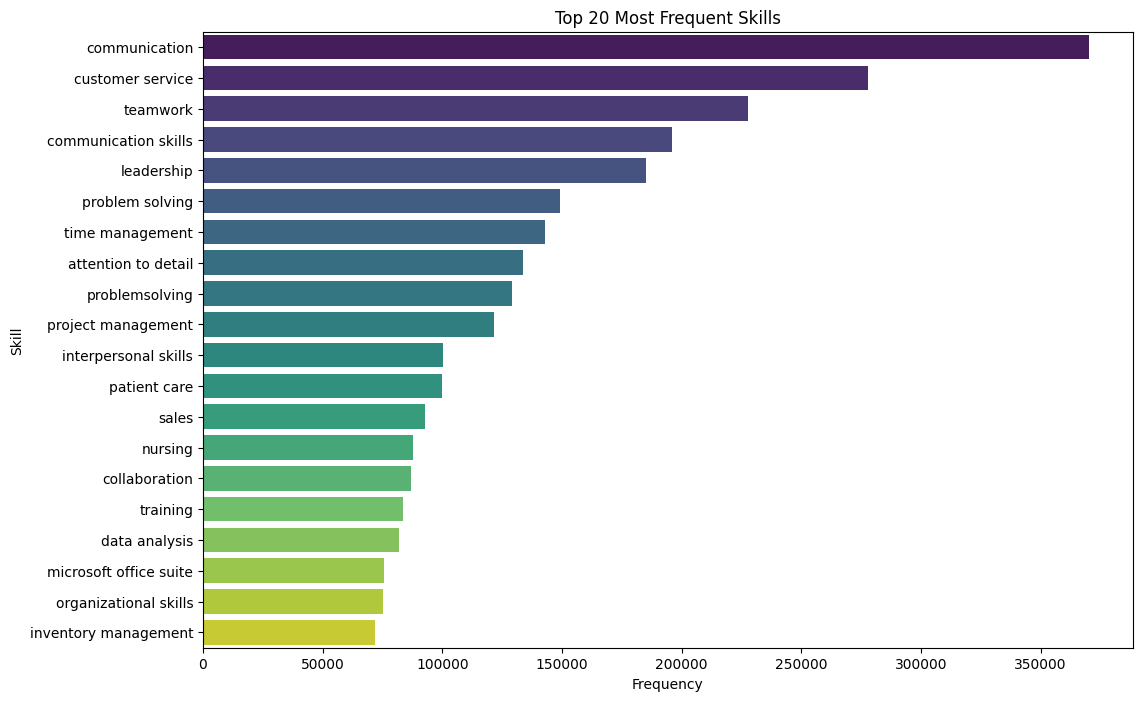

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_20_skills = skill_counts.limit(20).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='skill', data=top_20_skills, palette='viridis')
plt.title('Top 20 Most Frequent Skills')
plt.xlabel('Frequency')
plt.ylabel('Skill')
plt.show()

## Analyze Skills per Job Title with Visualization


**Reasoning**:
First, I need to extract the top 10 job titles and top 20 skills from their respective Spark DataFrames into Python lists.


In [ ]:
top_job_titles_list = [row.job_title_clean for row in top_10_job_titles.collect()]
top_20_skills_list = [row.skill for row in skill_counts.limit(20).collect()]

print("Top 10 Job Titles:", top_job_titles_list)
print("Top 20 Skills:", top_20_skills_list)

Top 10 Job Titles: ['LEAD SALES ASSOCIATE-FT', 'Shift Manager', 'First Year Tax Professional', 'Assistant Manager', 'Customer Service Representative', 'LEAD SALES ASSOCIATE-PT', 'Store Manager', 'CUSTOMER SERVICE REPRESENTATIVE', 'Registered Nurse', 'Hourly Supervisor & Training']
Top 20 Skills: ['communication', 'customer service', 'teamwork', 'communication skills', 'leadership', 'problem solving', 'time management', 'attention to detail', 'problemsolving', 'project management', 'interpersonal skills', 'patient care', 'sales', 'nursing', 'collaboration', 'training', 'data analysis', 'microsoft office suite', 'organizational skills', 'inventory management']


In [ ]:
filtered_skills_df = df_skills_exploded.filter(
    (col("job_title_clean").isin(top_job_titles_list)) &
    (col("skill").isin(top_20_skills_list))
)

skill_job_title_counts = filtered_skills_df.groupBy("job_title_clean", "skill").count()

skill_job_title_counts_pd = skill_job_title_counts.toPandas()

print("Sample of skill_job_title_counts_pd:")
display(skill_job_title_counts_pd.head())

Sample of skill_job_title_counts_pd:


,job_title_clean,skill,count
0,Hourly Supervisor & Training,inventory management,2447
1,First Year Tax Professional,attention to detail,350
2,Store Manager,customer service,3900
3,Store Manager,collaboration,90
4,CUSTOMER SERVICE REPRESENTATIVE,leadership,19


**Reasoning**:
- pivot table from the `skill_job_title_counts_pd` DataFrame, with `job_title_clean` as index, `skill` as columns.  
- filling NaN with 0
- then, heatmap using this pivoted table to visualize skill frequency per job title


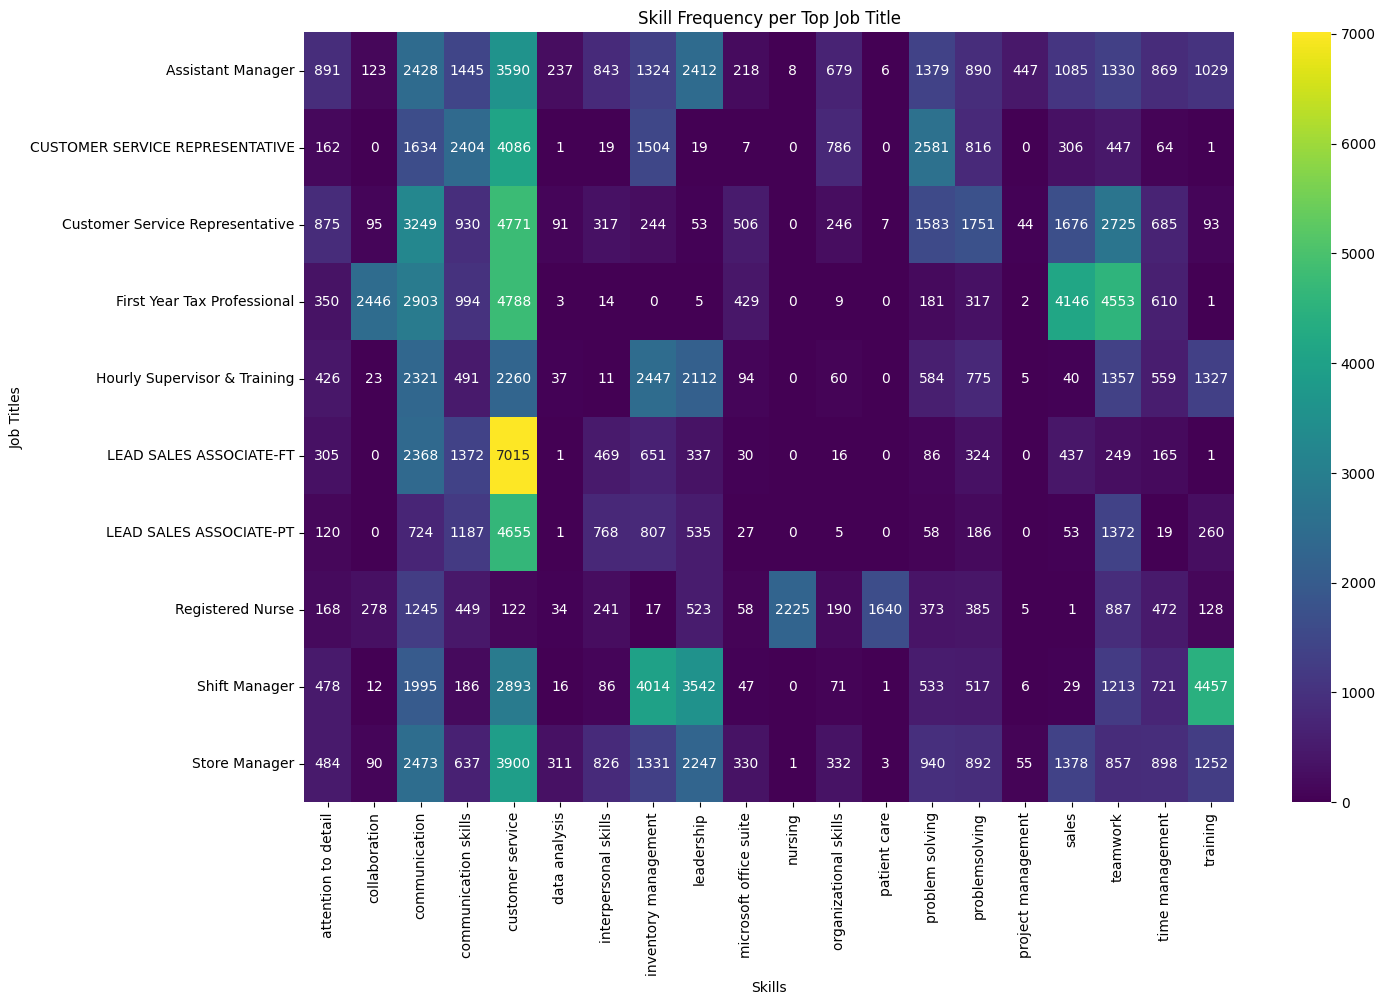

In [ ]:
pivot_table = skill_job_title_counts_pd.pivot_table(index='job_title_clean', columns='skill', values='count').fillna(0)

plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='viridis')
plt.title('Skill Frequency per Top Job Title')
plt.xlabel('Skills')
plt.ylabel('Job Titles')
plt.show()

## Insights

### Summary of Key Analytical Insights

1. **Overall Most In-Demand Skills**:
   -  'communication' and 'customer service' are the two most overwhelmingly in-demand skills
   - followed by 'teamwork', 'communication skills' (reaffirming the importance of communication), and 'leadership'.
   - Soft skills( such as problem-solving, time management, and attention to detail) also rank highly, suggesting their universal value across various roles.

2. **Skill Sets Unique to Specific Job Titles**:
   - **"Registered Nurse"**:    
        - Unsurprisingly, 'patient care' and 'nursing' are highly specific and dominant skills
        - along with 'communication' and 'interpersonal skills', highlighting the critical patient-facing aspect.

   - **"Hourly Supervisor & Training"**:     
        - a strong demand for 'inventory management' and 'training'
        - looks reflecting its operational and developmental responsibilities.
   - **"LEAD SALES ASSOCIATE-FT" / "LEAD SALES ASSOCIATE-PT"**:   
        - 'sales', 'customer service', 'communication', and 'leadership' are important
        - they are core to retail and sales management.

3. **Trends in Skill Demand for Popular Job Titles**:
   - A significant trend is the high demand for **soft skills** across almost all top job titles. ( like 'communication', 'customer service', 'teamwork', 'leadership', and 'problem solving')
   - This suggests that employers highly value these foundational interpersonal and cognitive abilities.

# Expand Job titles Analysis

## Analyze Job Titles vs Job Level with Visualization

Analyze the relationship between job titles and job levels by visualizing the distribution of job levels for each of the top job titles using a stacked bar chart.


In [ ]:
df_job_title_level = df_jobs_clean.filter(col("job_title_clean").isin(top_job_titles_list))
df_job_title_level_counts = df_job_title_level.groupBy("job_title_clean", "job_level").count()
df_job_title_level_counts_pd = df_job_title_level_counts.toPandas()

print("Sample of df_job_title_level_counts_pd:")
display(df_job_title_level_counts_pd.head())

Sample of df_job_title_level_counts_pd:


,job_title_clean,job_level,count
0,Assistant Manager,Associate,80
1,Registered Nurse,Mid senior,3879
2,Store Manager,Associate,140
3,Hourly Supervisor & Training,Mid senior,2955
4,LEAD SALES ASSOCIATE-FT,Mid senior,7325


<Figure size 1400x800 with 0 Axes>

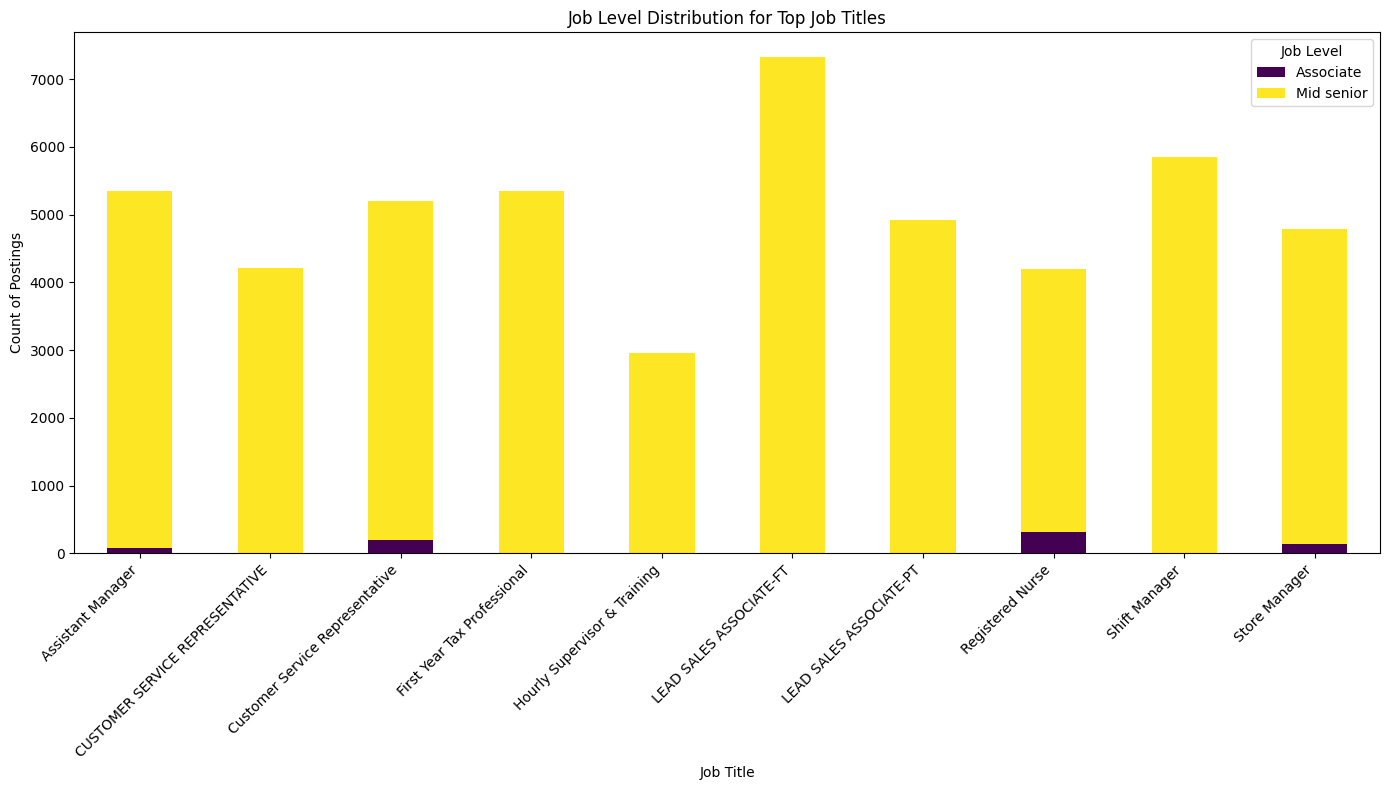

In [ ]:
job_level_pivot = df_job_title_level_counts_pd.pivot_table(index='job_title_clean', columns='job_level', values='count').fillna(0)

plt.figure(figsize=(14, 8))
job_level_pivot.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))
plt.title('Job Level Distribution for Top Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Count of Postings')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Job Level')
plt.tight_layout()
plt.show()

## Analyze Job Titles vs Job Type with Visualization

In [ ]:
df_job_title_type = df_jobs_clean.filter(col("job_title_clean").isin(top_job_titles_list))
df_job_title_type_counts = df_job_title_type.groupBy("job_title_clean", "job_type").count()
df_job_title_type_counts_pd = df_job_title_type_counts.toPandas()

print("Sample of df_job_title_type_counts_pd:")
display(df_job_title_type_counts_pd.head())

Sample of df_job_title_type_counts_pd:


,job_title_clean,job_type,count
0,Store Manager,Onsite,4792
1,LEAD SALES ASSOCIATE-PT,Onsite,4924
2,Shift Manager,Onsite,5856
3,Assistant Manager,Onsite,5346
4,Customer Service Representative,Onsite,5204


## Prepare Job Data for Location Analysis
Split the `df_jobs_clean` dataset into separate dataframes for the United States, Canada, and other countries.


In [ ]:
df_jobs_us = df_jobs_clean.filter(col("search_country") == "United States")
df_jobs_canada = df_jobs_clean.filter(col("search_country") == "Canada")
df_jobs_other = df_jobs_clean.filter(
    (col("search_country") != "United States") &
    (col("search_country") != "Canada")
)

print(f"Number of jobs in United States: {df_jobs_us.count()}")
print(f"Number of jobs in Canada: {df_jobs_canada.count()}")
print(f"Number of jobs in other countries: {df_jobs_other.count()}")

Number of jobs in United States: 1149323
Number of jobs in Canada: 55971
Number of jobs in other countries: 143130


## Identify Top 5 US Cities

In [ ]:
city_distribution = df_jobs_us.groupBy("search_city").count().orderBy(col("count").desc())
top_5_us_cities = city_distribution.limit(5).toPandas()

print("Top 5 US Cities with Most Job Postings:")
display(top_5_us_cities)

Top 5 US Cities with Most Job Postings:


,search_city,count
0,Baytown,10052
1,North Carolina,10015
2,Garland,9739
3,Austin,8897
4,South Carolina,8385


## Analyze Top 5 Job Titles per City
For each of the top 5 US cities, determine the top 5 job titles by posting count.


In [76]:
top_5_us_cities_list = top_5_us_cities['search_city'].tolist()

df_top_us_cities_jobs = df_jobs_us.filter(col('search_city').isin(top_5_us_cities_list))

us_city_job_title_counts = df_top_us_cities_jobs.groupBy('search_city', 'job_title_clean').count()

us_city_job_title_counts.createOrReplaceTempView("us_city_job_titles")

top_5_job_titles_per_us_city_sql = """SELECT search_city, job_title_clean, count
                                      FROM (
                                          SELECT search_city, job_title_clean, count,
                                                 ROW_NUMBER() OVER (PARTITION BY search_city ORDER BY count DESC) as rn
                                          FROM us_city_job_titles
                                      ) AS ranked_jobs
                                      WHERE rn <= 5
                                      ORDER BY search_city, count DESC"""

top_5_job_titles_per_us_city = spark.sql(top_5_job_titles_per_us_city_sql)

top_5_job_titles_per_us_city_pd = top_5_job_titles_per_us_city.toPandas()

print("Top 5 Job Titles for Each of the Top 5 US Cities:")
display(top_5_job_titles_per_us_city_pd.head(25))

Top 5 Job Titles for Each of the Top 5 US Cities:


,search_city,job_title_clean,count
0,Austin,Assistant General Manager,35
1,Austin,Store Manager,32
2,Austin,LEAD SALES ASSOCIATE-FT,30
3,Austin,Mechanical Engineer,29
4,Austin,Account Executive,28
5,Baytown,Customer Service Representative,33
6,Baytown,Account Executive,31
7,Baytown,Executive Assistant,28
8,Baytown,Maintenance Supervisor,27
9,Baytown,CUSTOMER SERVICE REPRESENTATIVE,26


/tmp/ipython-input-2671709450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm')


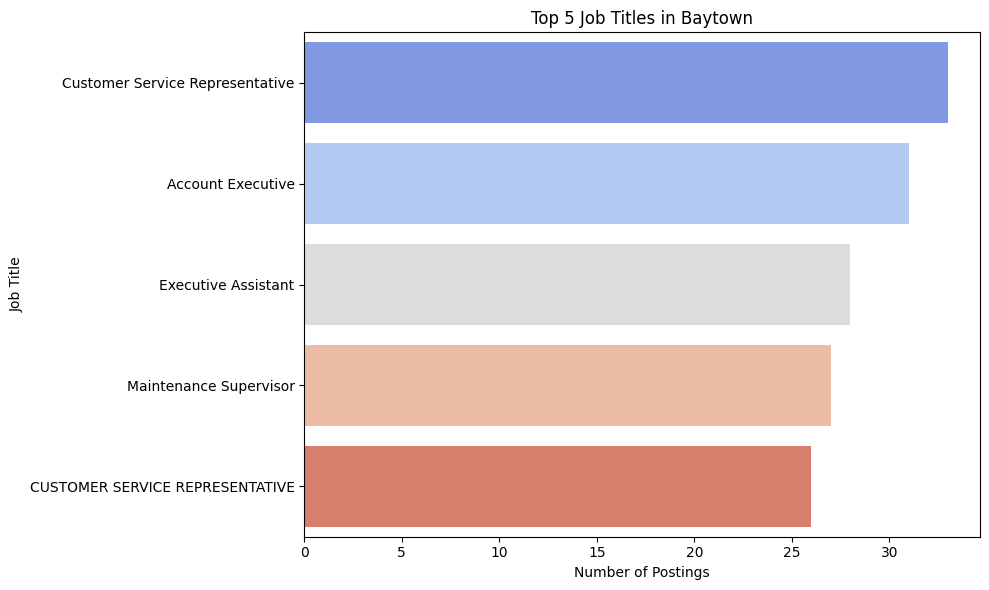

/tmp/ipython-input-2671709450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm')


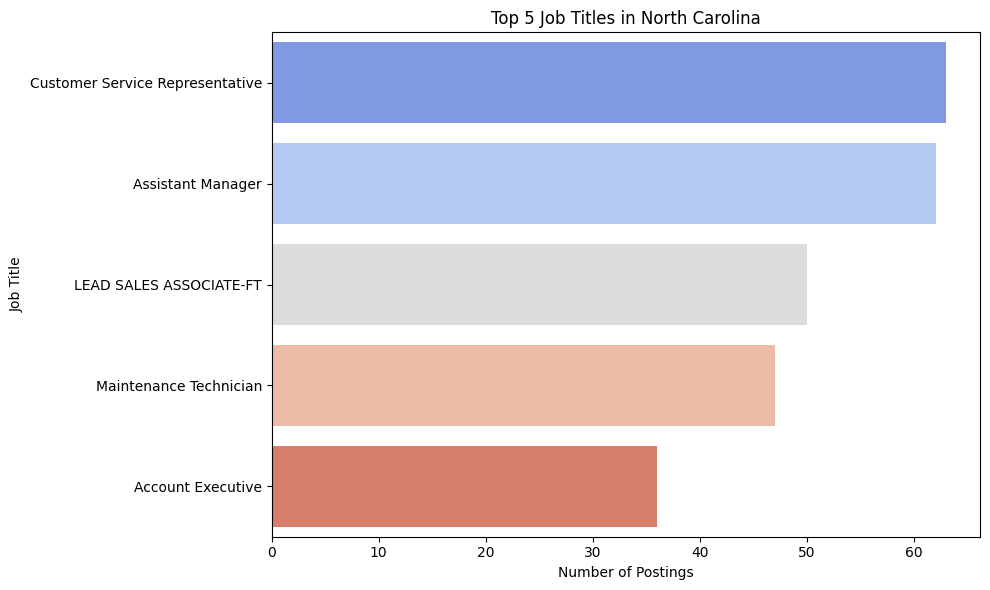

/tmp/ipython-input-2671709450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm')


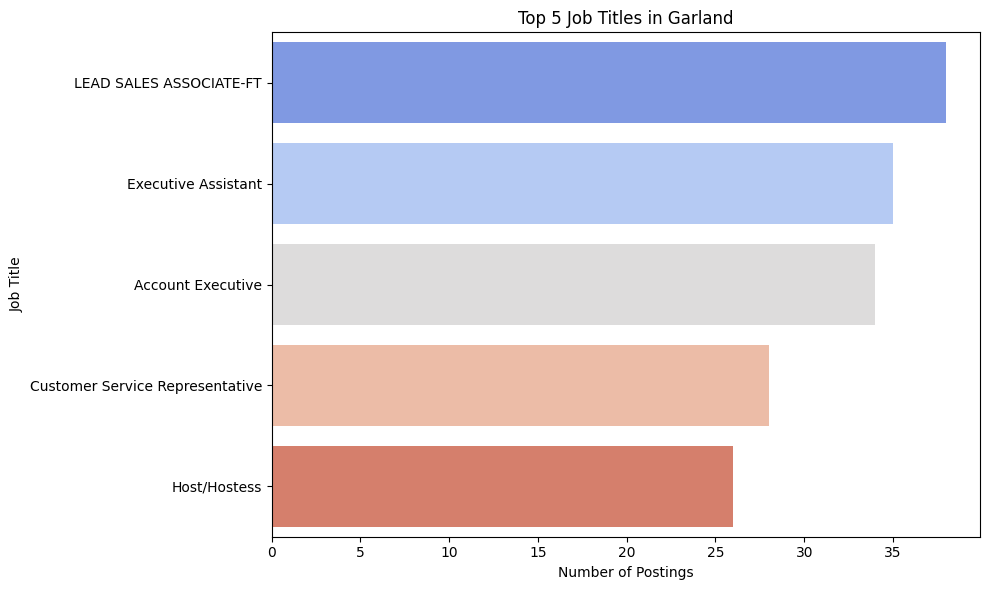

/tmp/ipython-input-2671709450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm')


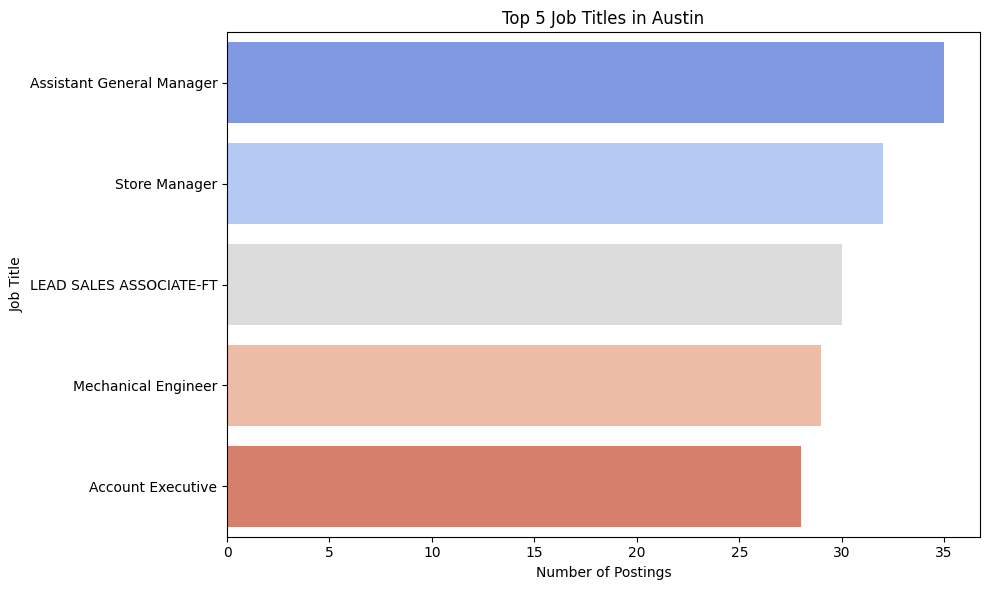

/tmp/ipython-input-2671709450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm')


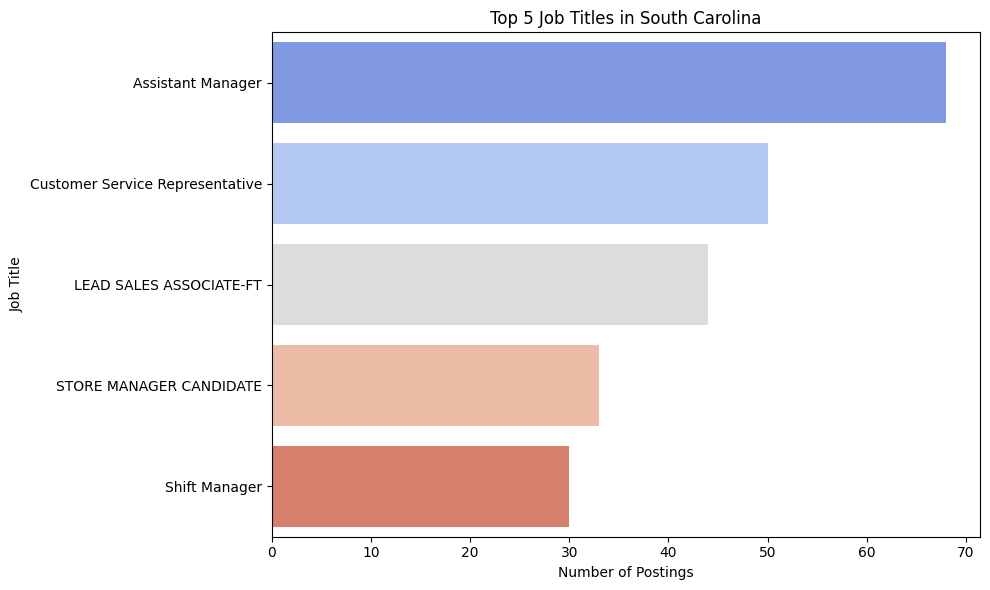

In [ ]:
for city in top_5_us_cities_list:
    city_data = top_5_job_titles_per_us_city_pd[top_5_job_titles_per_us_city_pd['search_city'] == city]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm')
    plt.title(f'Top 5 Job Titles in {city}')
    plt.xlabel('Number of Postings')
    plt.ylabel('Job Title')
    plt.tight_layout()
    plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` because `palette` was used without assigning `hue` in `sns.barplot`. To resolve this and ensure compatibility with future versions of seaborn, I will explicitly set the `hue` parameter to the `y` variable (`job_title_clean`) and add `legend=False`.



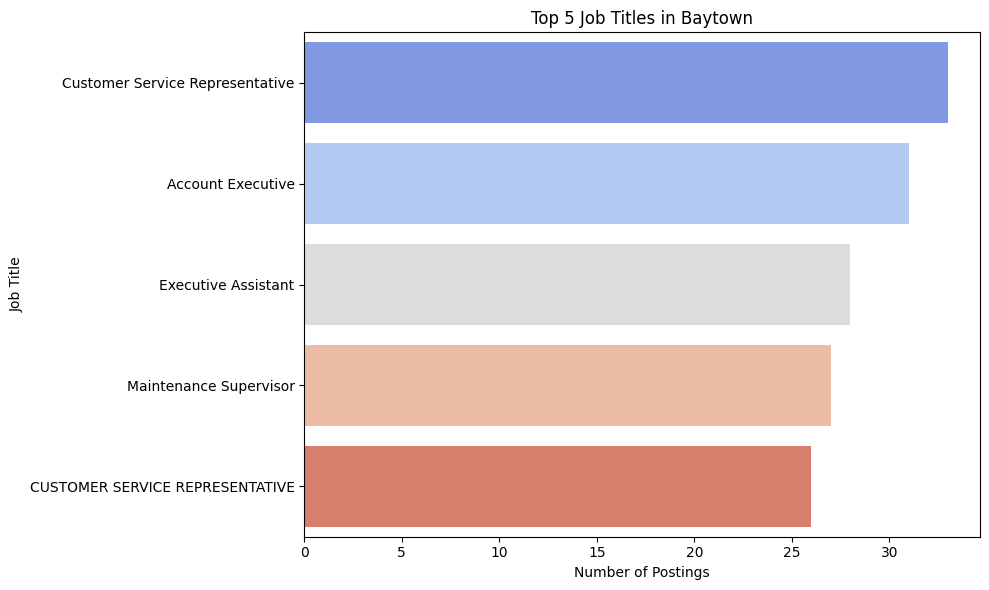

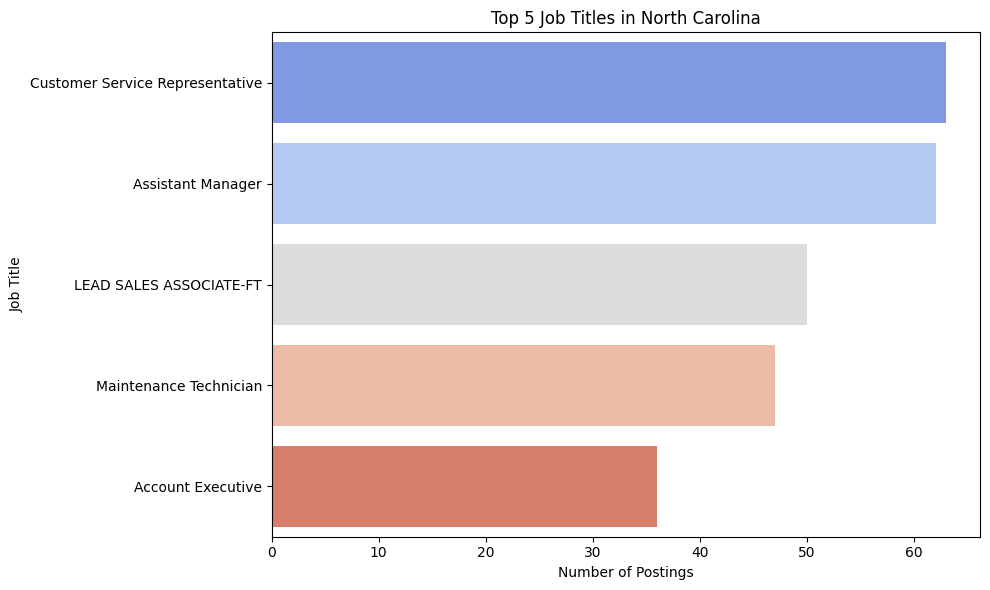

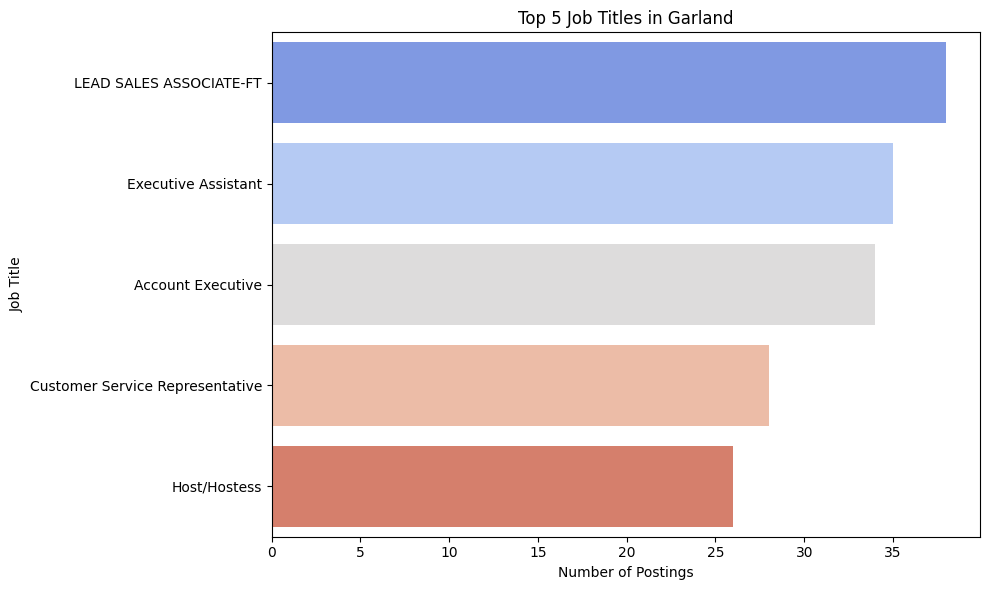

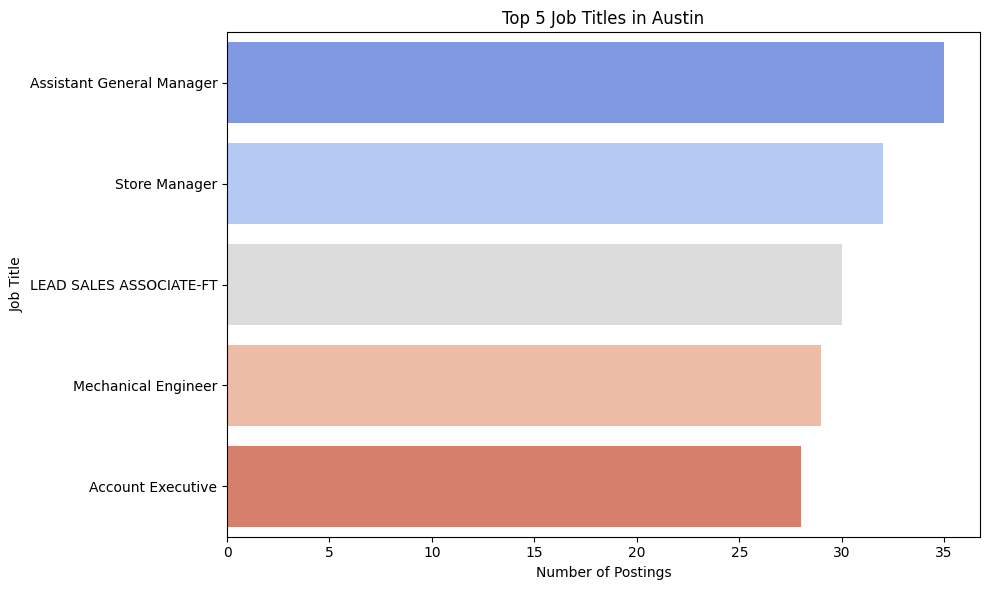

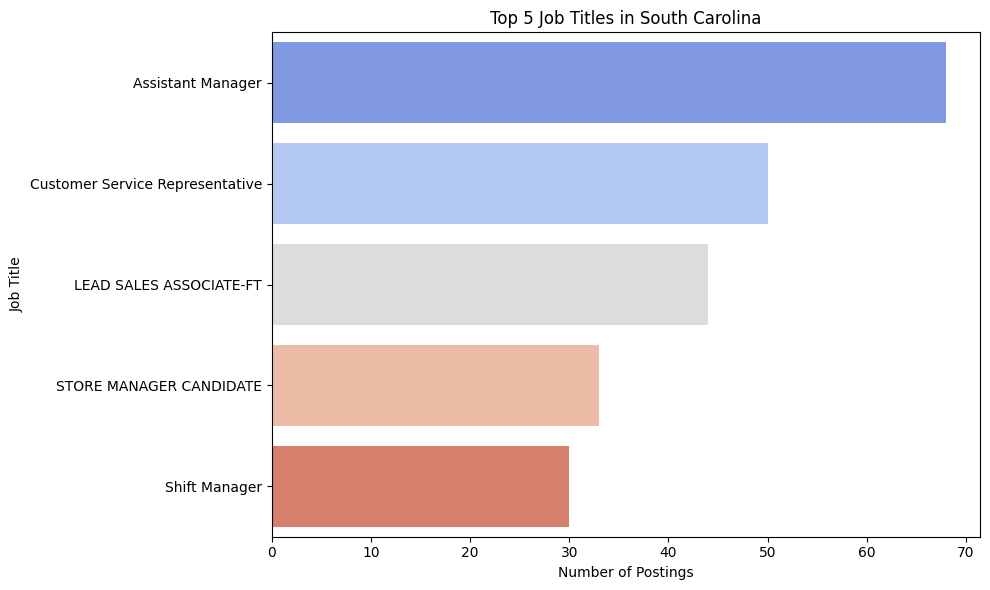

In [ ]:
for city in top_5_us_cities_list:
    city_data = top_5_job_titles_per_us_city_pd[top_5_job_titles_per_us_city_pd['search_city'] == city]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm', hue='job_title_clean', legend=False)
    plt.title(f'Top 5 Job Titles in {city}')
    plt.xlabel('Number of Postings')
    plt.ylabel('Job Title')
    plt.tight_layout()
    plt.show()

### Insights on Job Demand Patterns in Top 5 US Cities

**Prevalence of Service and Retail Roles**:   
- Roles such as 'Assistant Manager', 'LEAD SALES ASSOCIATE-FT', 'Customer Service Representative', and 'Shift Manager' frequently appear across multiple top cities.    
- This indicates a consistent demand for service and retail management positions.

**City-Specific Specializations**:
   - **Austin**: Shows a demand for 'Mechanical Engineer' and 'Account Executive', hinting at a tech or corporate sales presence.
   - **Baytown**: Features 'Maintenance Supervisor' and 'CUSTOMER SERVICE REPRESENTATIVE', possibly indicating industrial or administrative support needs.
   - **Garland**: Includes 'Host/Hostess', suggesting a vibrant hospitality sector.
   - **North Carolina**: Has 'Maintenance Technician' and 'Assistant Manager', reflecting a mix of skilled trades and retail leadership.
   - **South Carolina**: Highlights 'STORE MANAGER CANDIDATE' and 'Assistant Manager', emphasizing retail management growth.

# Task
Identify the top 5 Canadian cities with the most job postings from `df_jobs_canada`.

## Identify Top Canadian Cities


In [77]:
city_distribution_canada = df_jobs_canada.groupBy("search_city").count().orderBy(col("count").desc())
top_5_canada_cities = city_distribution_canada.limit(5).toPandas()

print("Top 5 Canadian Cities with Most Job Postings:")
display(top_5_canada_cities)

Top 5 Canadian Cities with Most Job Postings:


,search_city,count
0,Sarnia-Clearwater,7887
1,Etobicoke,4065
2,Côte-Saint-Luc,3703
3,New Westminster,3324
4,Alberta,2352


## Analyze Top Job Titles per Canadian City


In [78]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# 1. Extract the list of top 5 Canadian cities
top_5_canada_cities_list = top_5_canada_cities['search_city'].tolist()

# 2. Filter df_jobs_canada to include only job postings from these top 5 Canadian cities.
df_top_canada_cities_jobs = df_jobs_canada.filter(col('search_city').isin(top_5_canada_cities_list))

# 3. Group the filtered Spark DataFrame by 'search_city' and 'job_title_clean', and then count the occurrences.
canada_city_job_title_counts = df_top_canada_cities_jobs.groupBy('search_city', 'job_title_clean').count()

# 4. Create a temporary view from this grouped Spark DataFrame
canada_city_job_title_counts.createOrReplaceTempView("canada_city_job_titles")

# 5. Write a Spark SQL query to select 'search_city', 'job_title_clean', and 'count',
# and apply a window function using ROW_NUMBER() partitioned by 'search_city'
# and ordered by 'count' in descending order. Filter the results to include only the top 5 job titles for each city.
top_5_job_titles_per_canada_city_sql = """SELECT search_city, job_title_clean, count
                                      FROM (
                                          SELECT search_city, job_title_clean, count,
                                                 ROW_NUMBER() OVER (PARTITION BY search_city ORDER BY count DESC) as rn
                                          FROM canada_city_job_titles
                                      ) AS ranked_jobs
                                      WHERE rn <= 5
                                      ORDER BY search_city, count DESC"""

# 6. Execute the Spark SQL query and convert the resulting Spark DataFrame to a Pandas DataFrame.
top_5_job_titles_per_canada_city = spark.sql(top_5_job_titles_per_canada_city_sql)
top_5_job_titles_per_canada_city_pd = top_5_job_titles_per_canada_city.toPandas()

# 7. Display the head of the resulting Pandas DataFrame to inspect the data.
print("Top 5 Job Titles for Each of the Top 5 Canadian Cities:")
display(top_5_job_titles_per_canada_city_pd.head(25))

Top 5 Job Titles for Each of the Top 5 Canadian Cities:


,search_city,job_title_clean,count
0,Alberta,Registered Nurse,25
1,Alberta,Physiotherapist,23
2,Alberta,Gas Plant Shift Lead 2nd Class Steam Ticket,17
3,Alberta,Food Service Supervisor,13
4,Alberta,Industrial Cleaning Field Supervisor,13
5,Côte-Saint-Luc,Assistant-Grant,21
6,Côte-Saint-Luc,Customer Service Representative,18
7,Côte-Saint-Luc,INFIRMIER OU INFIRMIRE - Chirurgie trauma 2 Su...,15
8,Côte-Saint-Luc,INFIRMIER OU INFIRMIRE - Hmodialyse en milieu ...,14
9,Côte-Saint-Luc,INFIRMIER OU INFIRMIRE - Oncologie - Mdecine s...,13


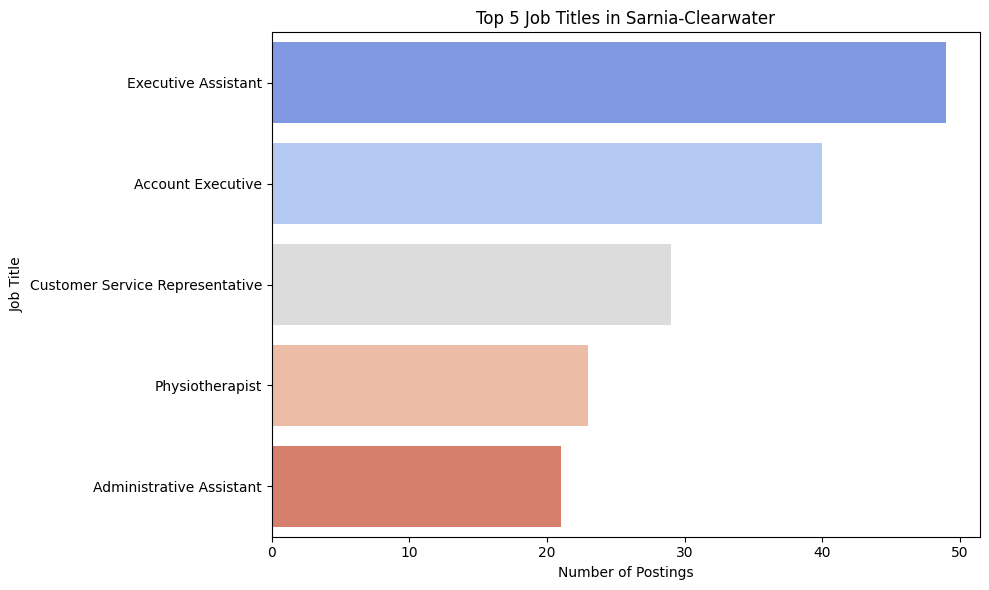

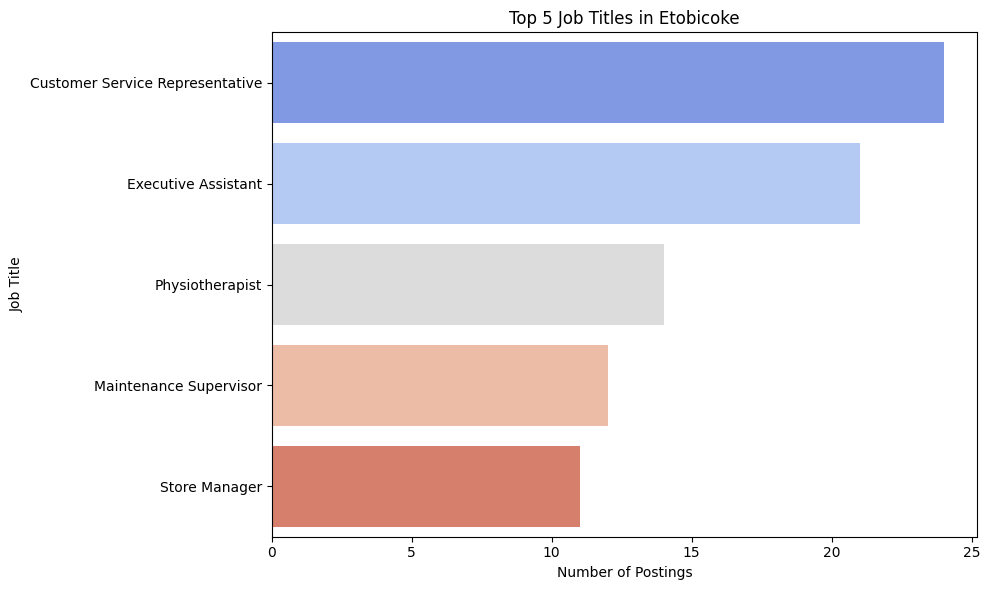

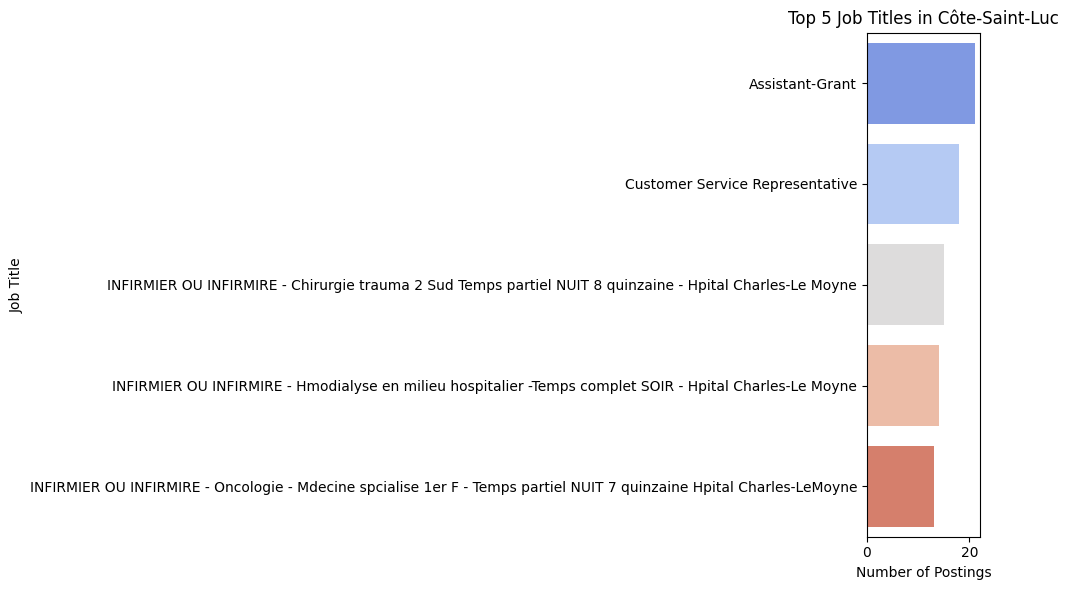

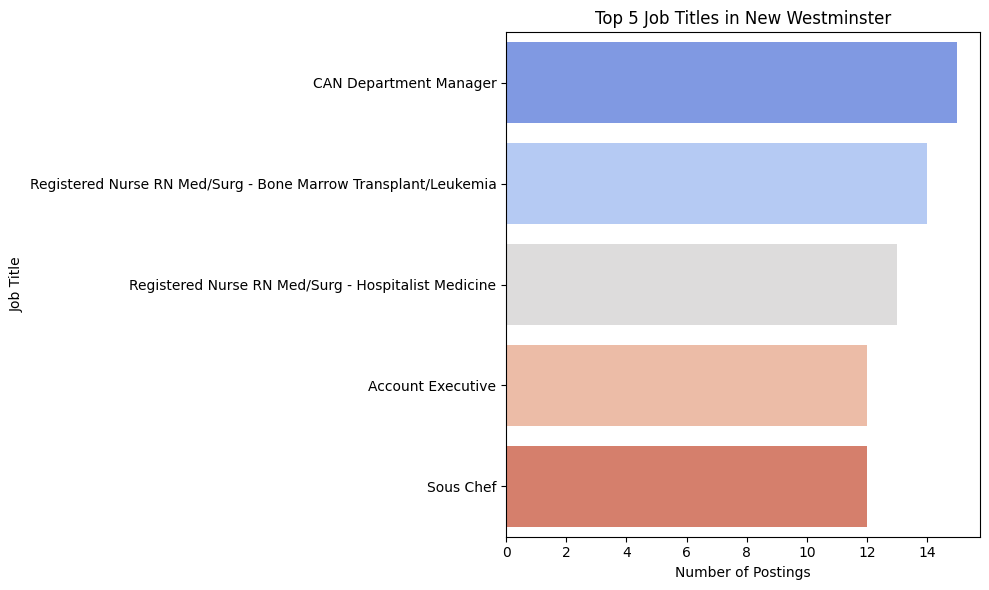

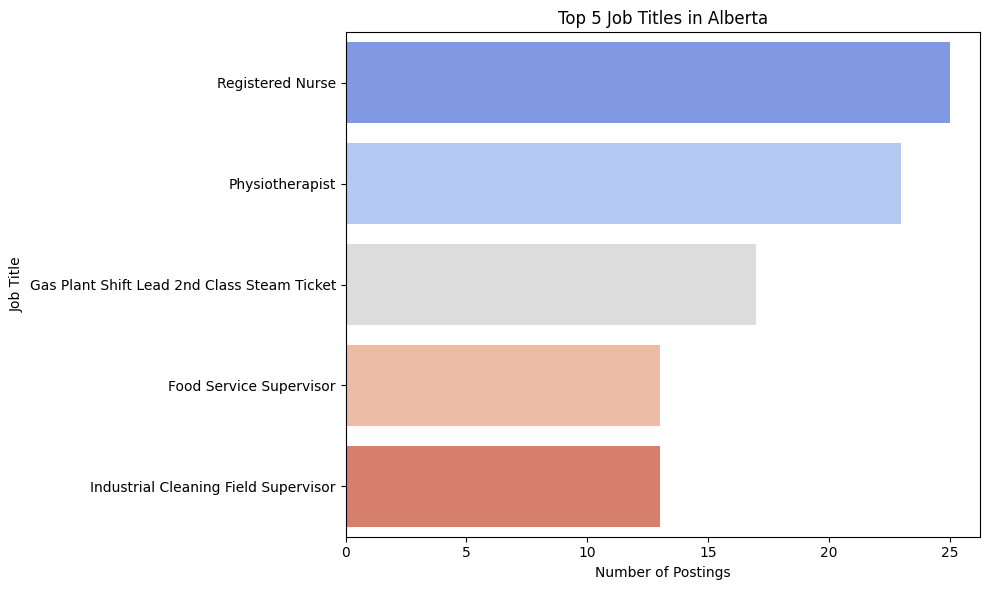

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

for city in top_5_canada_cities_list:
    city_data = top_5_job_titles_per_canada_city_pd[top_5_job_titles_per_canada_city_pd['search_city'] == city]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='job_title_clean', data=city_data, palette='coolwarm', hue='job_title_clean', legend=False)
    plt.title(f'Top 5 Job Titles in {city}')
    plt.xlabel('Number of Postings')
    plt.ylabel('Job Title')
    plt.tight_layout()
    plt.show()

### Insights on Job Demand Patterns in Top 5 Canadian Cities

**1. 'Sarnia-Clearwater':**
- Administrative & Sales Support
- Healthcare Support
- Customer Service

**2. 'Etobicoke':**
- Service & Support
- Healthcare & Retail Management

**3. 'Côte-Saint-Luc':**
- Healthcare Dominance
- Administrative & Customer Service

**4. 'New Westminster':**
- Retail Management & Healthcare
- Sales & Hospitality

**5. 'Alberta':**
- Healthcare & Industrial
- Food Service

## Summary:

1.  **Which are the top 5 Canadian cities with the most job postings?**.  
The top 5 Canadian cities with the most job postings are: Sarnia-Clearwater (7887 postings), Etobicoke (4065 postings), Côte-Saint-Luc (3703 postings), New Westminster (3324 postings), and Alberta (2352 postings).

2.  **What are the top 5 job titles in each of these top 5 Canadian cities?**
    *   **Sarnia-Clearwater:** Executive Assistant, Administrative Assistant, Account Executive, Physiotherapist, Customer Service Representative.
    *   **Etobicoke:** Customer Service Representative, Executive Assistant, Physiotherapist, Maintenance Supervisor, Store Manager.
    *   **Côte-Saint-Luc:** INFIRMIER OU INFIRMIÈRE AUXILIAIRE - HÉMODIALYSE, INFIRMIER OU INFIRMIÈRE - CHIRURGIE, INFIRMIER OU INFIRMIÈRE - ONCOLOGIE, Assistant-Grant, Customer Service Representative.
    *   **New Westminster:** CAN Department Manager, Registered Nurse, Account Executive, Sous Chef, Store Manager.
    *   **Alberta:** Registered Nurse, Physiotherapist, Gas Plant Shift Lead 2nd Class Steam Ticket, Industrial Cleaning Field Supervisor, Food Service Supervisor.
